# Alcance

En este trabajo vamos a implementar el modelo SCIR desarrollado en el paper : https://arxiv.org/pdf/2004.08842v2.pdf , cuyo código y datos están en el repositorio  https://github.com/mariocastro73/predictability. Este repositorio está escrito en `R`, en este trabajo pretendo escribir un modelo simplificado en `Python`, con la ayuda de la librería de modelos bayesianos https://docs.pymc.io utilizada para la inferencia de los parámetros de las ecuaciones que modelan el comportamiento de los compartimentos Susceptibles, Infected, Confined, Deceased...


Empezamos como siempre importando las librerías de uso cotidiano para estos trabajos.
He deshabilitado los warnings para facilidad de presentación de datos.

In [219]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib import cm
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.dates import (YEARLY, MONTHLY, DateFormatter, MonthLocator,DayLocator,
                              rrulewrapper, RRuleLocator, drange)
from scipy.integrate import odeint
import numpy as np
from datetime import datetime
import seaborn as sns
%matplotlib inline
import arviz as az
import urllib.request
import pymc3 as pm
import theano.tensor as tt
import warnings;
warnings.filterwarnings('ignore');

Preparamos la descarga de datos desde el repositorio de [@alfonsotwr](https://twitter.com/alfonsotwr) que está haciendo un trabajo impagable de recopilación, auditoria y presentación de datos de los datos epidemiológicos de la Comunidad de Madrid

In [220]:
path_datos='https://github.com/alfonsotwr/snippets/blob/master/covidia-cam/madrid-series.csv?raw=true'

In [116]:
df = pd.read_csv(path_datos,parse_dates=['Fecha'],date_parser=lambda d: pd.to_datetime(d, format="%Y/%m/%d", errors="coerce"))

In [117]:
df.columns

Index(['Fecha', 'CASOS_PCR', 'Hospitalizados', 'UCI', 'Fallecidos',
       'Recuperados', 'domicilio', 'uci_dia', 'hospitalizados_dia',
       'domicilio_dia', 'altas_dia', 'fallecidos_dia', 'muertos_hospitales',
       'muertos_domicilios', 'muertos_centros', 'muertos_otros', 'muertos'],
      dtype='object')

Vemos los datos de las columnas que nos interesan..

In [221]:
df[['Fecha','CASOS_PCR','muertos','Recuperados']]

,Fecha,CASOS_PCR,muertos,Recuperados
103,2020-08-17,96947,15271,44098
104,2020-08-18,98797,15271,44196
105,2020-08-19,100688,15304,44314
106,2020-08-20,103337,15304,44418
107,2020-08-21,106215,15330,44547
108,2020-08-24,112189,15342,44783
109,2020-08-25,114096,15342,44956
110,2020-08-26,116269,15392,45131
111,2020-08-27,118887,15392,45304
112,2020-08-28,122394,15428,45493


podemos comprobar que los datos presentados son acumulados

Preparamos los datos a continuación. Para ello vamos a: 
- filtrar desde una fecha `fecha_inicio`..
- Eliminamos los`nan`
- generamos una columna con los datos de `infected`, necesaria para el cálculo posterior
- generamos una columna con los datos X, equivalente a la suma de recuperados y fallecidos. Son los correspondientes a R+D en el módelo del paper
- generamos los arrays correspondientes a la linea de tiempo, infected, con su log, y X con su log

In [237]:
fecha_inicio=datetime(year=2020,month=8,day=15)

df = df.fillna(0,axis=1)
df = df[(df['Fecha']>=fecha_inicio)]

color_avg = 'darkred'
color_titulos = 'navy'
color_diarios = 'royalblue'

df['infected'] = df['CASOS_PCR']-df['muertos']-df['Recuperados']

df['X'] = df['muertos']+df['Recuperados']
#df['X'] = df['X'].diff().rolling(window=7).mean()
df['X'] = df['X'].diff()

infected = np.array(df['infected'][1:])
infected_log = np.log(infected)
X = np.array(df['X'])[1:]
X_log = np.log(X)
t=np.array([i for i in range(len(infected))])

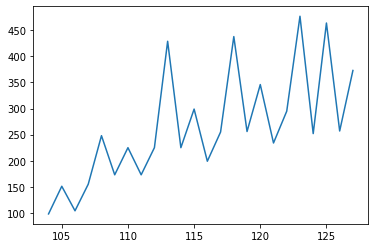

In [166]:
df['X'].plot()

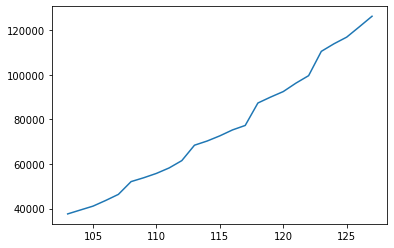

In [167]:
df['infected'].plot()

Empezamos con el modelo. Tal como se indica en el paper preparamos los `prior`de los parámetros. Tengo una cuestión aun sin resolver, referente a la codificación de la sigma_I, tal como aparece en el código `R`debería de ser `sigma_I = pm.Gamma(name='sigmaI',alpha=0.01,beta=0.01)`, sin embargo en otras implementaciones, [aquí](https://martynplummer.wordpress.com/2016/01/11/pyjags/), he visto tal que `1/tt.sqrt(pm.sigma...)`. Seguiré investigando a ver cual es el correcto.

Hacemos el `sample` con los mismos parámetros de `draw`y `tune` que el paper y ejecutamos:

In [222]:
with pm.Model() as model:
    #t = pm.Data('tiempo',range(len(casos_nuevos)))
    t_ = t
    beta = pm.Uniform('beta',lower=0,upper=1)
    r_mu = pm.Uniform('r_mu',lower=0,upper=1)
    #p = pm.Uniform('p',lower=0,upper=5)
    #q = pm.Uniform('q',lower=0,upper=5)
    
    #sigma_I = 1/tt.sqrt(pm.Gamma(name='sigmaI',alpha=0.01,beta=0.01))
    sigma_I = pm.Gamma(name='sigmaI',alpha=0.01,beta=0.01)
    
    #R0 = pm.Deterministic('R0',beta/r_mu)
    #R0_ = pm.Deterministic('R0_',beta/r_mu)
    #media = pm.Deterministic('media',casos_acumulados_log[0]+(R0_-1)*(r_mu)*t_)
    
    #R0 = beta/r_mu
    #R0_ = beta/(r_mu)
    #media = infected_log[0]+(R0_-1)*(r_mu)*(t_)
    media_I = infected_log[0]+(beta-r_mu)*t_
         
    log_I_obs = pm.Normal('log_I_obs',mu=media_I,sigma=sigma_I,observed=infected_log)
    media_X = log_I_obs+tt.log(r_mu)
    log_X_obs = pm.Normal('log_X_obs',mu=media_X,sigma=sigma_I,observed= X_log)
    step = pm.Metropolis()
    map_estimate = pm.find_MAP()
    trace = pm.sample(10000, tune=5000,step=step,start=map_estimate,
                      discard_tuned_samples=True)
    
    post_Pred = pm.sample_posterior_predictive(trace)

logp = 8.4598, ||grad|| = 12.424: 100%|██████████| 39/39 [00:00<00:00, 2384.41it/s]     
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigmaI]
>Metropolis: [r_mu]
>Metropolis: [beta]
Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:11<00:00, 5007.26draws/s]
The number of effective samples is smaller than 25% for some parameters.
100%|██████████| 40000/40000 [01:02<00:00, 640.44it/s]


Veamos el resultados:

pm.traceplot(trace)

In [224]:
pm.summary(trace).round(2)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta,0.06,0.00,0.05,0.06,0.0,0.0,7927.0,7927.0,7900.0,7758.0,1.0
r_mu,0.00,0.00,0.00,0.00,0.0,0.0,7918.0,7902.0,7852.0,7433.0,1.0
sigmaI,0.20,0.02,0.16,0.24,0.0,0.0,6356.0,6316.0,6452.0,7500.0,1.0


Aquí considero importante mostrar como podemos obtener los estadísticos mostrados de los parámetros, por ejemplo: mostremos la media de la distribución de la `beta`calculada:

In [240]:
pm.summary(trace).loc['beta','mean']

0.057

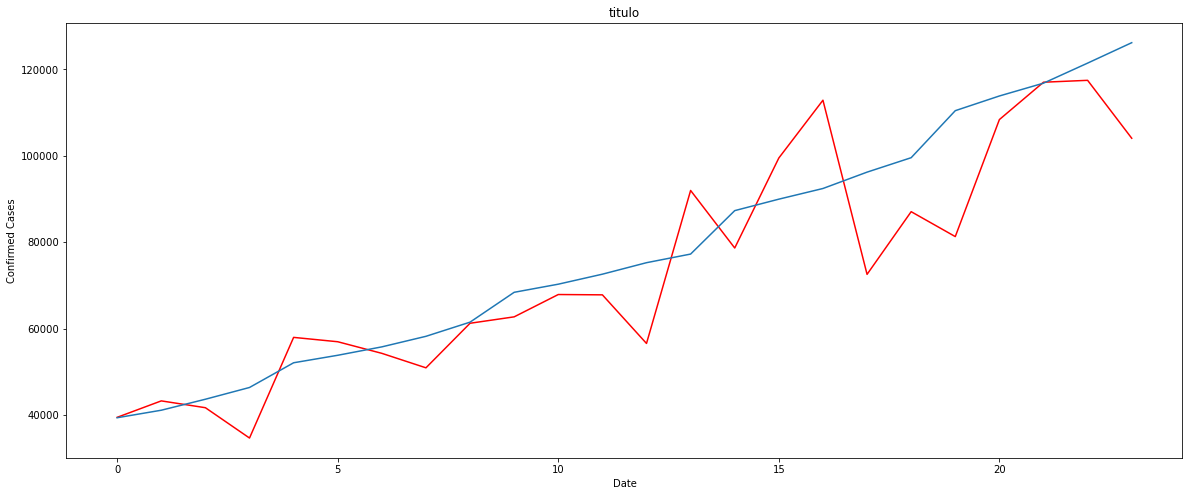

In [226]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(t, np.exp(post_Pred['log_I_obs'][1000].T), color="r", alpha=1)
ax.plot(t,infected)
#ax.set_yscale("log")
ax.set(xlabel="Date", ylabel="Confirmed Cases", title='titulo')
plt.show()

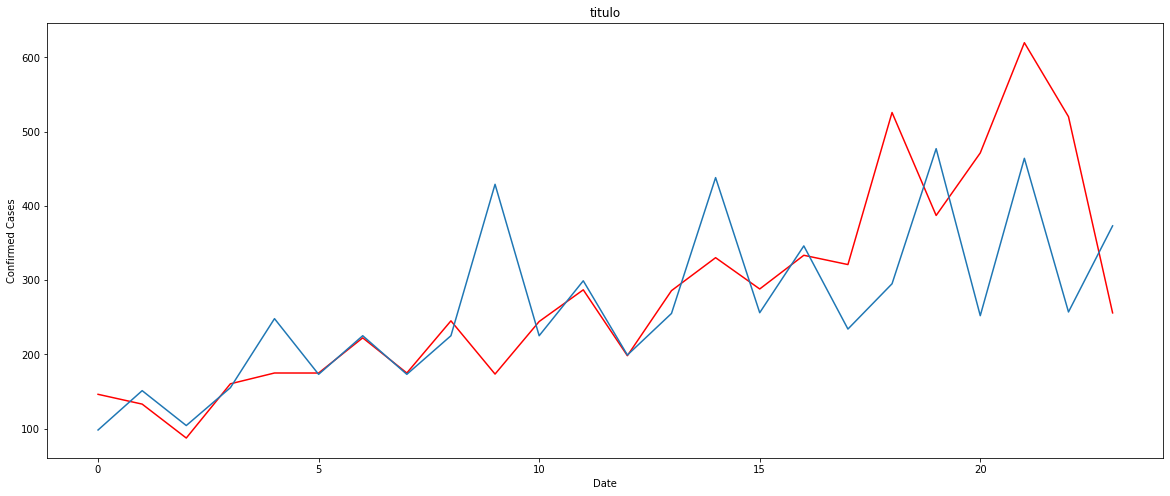

In [227]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(t, np.exp(post_Pred['log_X_obs'][100].T), color="r", alpha=1)
ax.plot(t,X)
#ax.set_yscale("log")
ax.set(xlabel="Date", ylabel="Confirmed Cases", title='titulo')
plt.show()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe7747e3b50>,
      dtype=object)

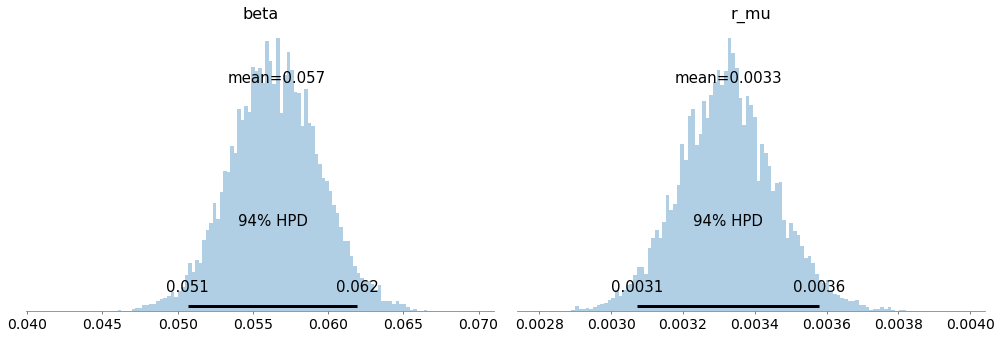

In [228]:
pm.plot_posterior(trace, var_names=(['beta','r_mu']), kind='hist')

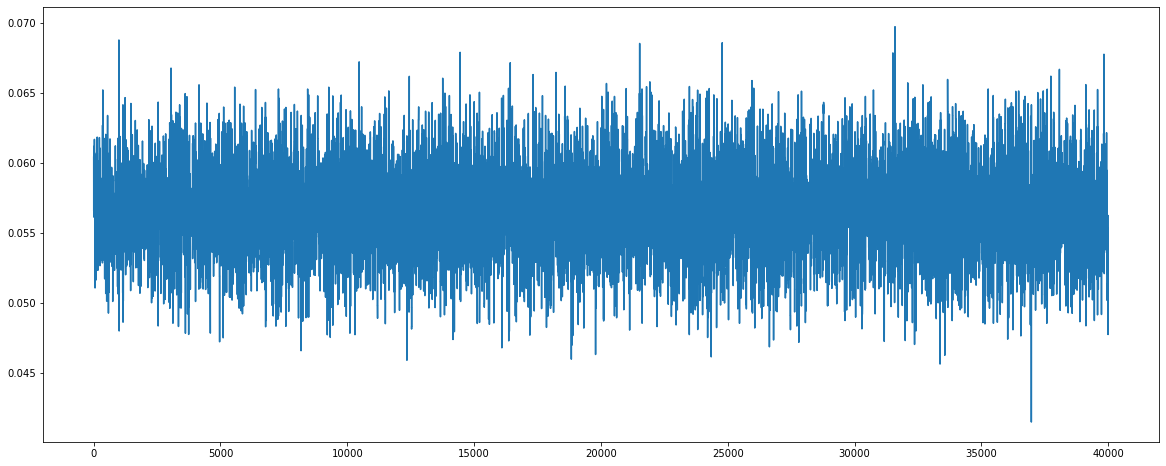

In [229]:
fig, ax = plt.subplots(figsize=(20, 8))

ax.plot(trace['beta'])

plt.show()

In [230]:
beta_ = trace['beta'].mean()
r_mu_ = trace['r_mu'].mean()
I_ = infected[0]*np.exp((beta_/r_mu_-1)*r_mu_*t)

In [231]:
beta_

0.056608059147301784

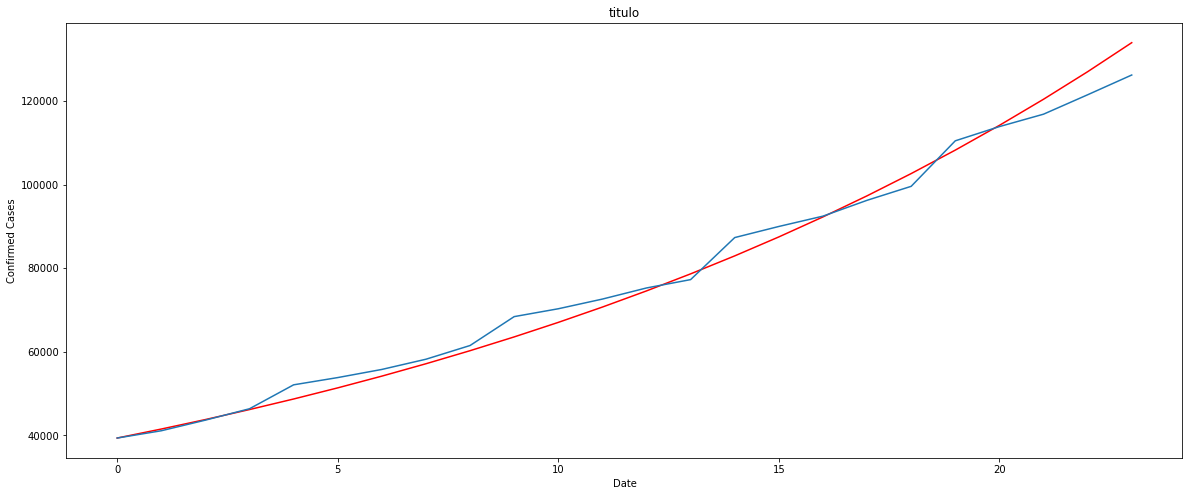

In [232]:
fig, ax = plt.subplots(figsize=(20, 8))
#ax.plot(t, np.exp(post_Pred['log_I_obs'][100].T), color="r", alpha=1)
ax.plot(t,I_,color='r')
ax.plot(t,infected)
#ax.set_yscale("log")
ax.set(xlabel="Date", ylabel="Confirmed Cases", title='titulo')
plt.show()

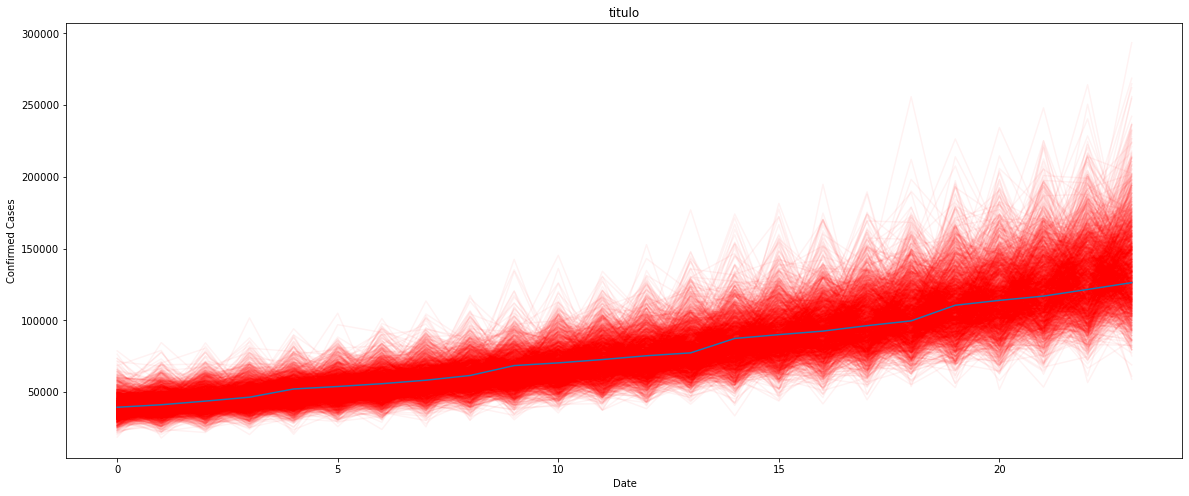

In [233]:
fig, ax = plt.subplots(figsize=(20, 8))
for i in range(2000):
               ax.plot(t, np.exp(post_Pred['log_I_obs'][i].T), color="r", alpha=0.05)
ax.plot(t,infected)
#ax.set_yscale("log")
ax.set(xlabel="Date", ylabel="Confirmed Cases", title='titulo')
plt.show()

In [234]:
beta_sup = pm.summary(trace).loc['beta']['hpd_97%']
beta_inf = pm.summary(trace).loc['beta']['hpd_3%']
r_mu_sup = pm.summary(trace).loc['r_mu']['hpd_97%']
r_mu_inf = pm.summary(trace).loc['r_mu']['hpd_3%']

In [235]:
beta_ = trace['beta'].mean()
r_mu_ = trace['r_mu'].mean()
I_sup = infected[0]*np.exp((beta_sup/r_mu_inf-1)*r_mu_*t)
I_inf = infected[0]*np.exp((beta_inf/r_mu_sup-1)*r_mu_*t)

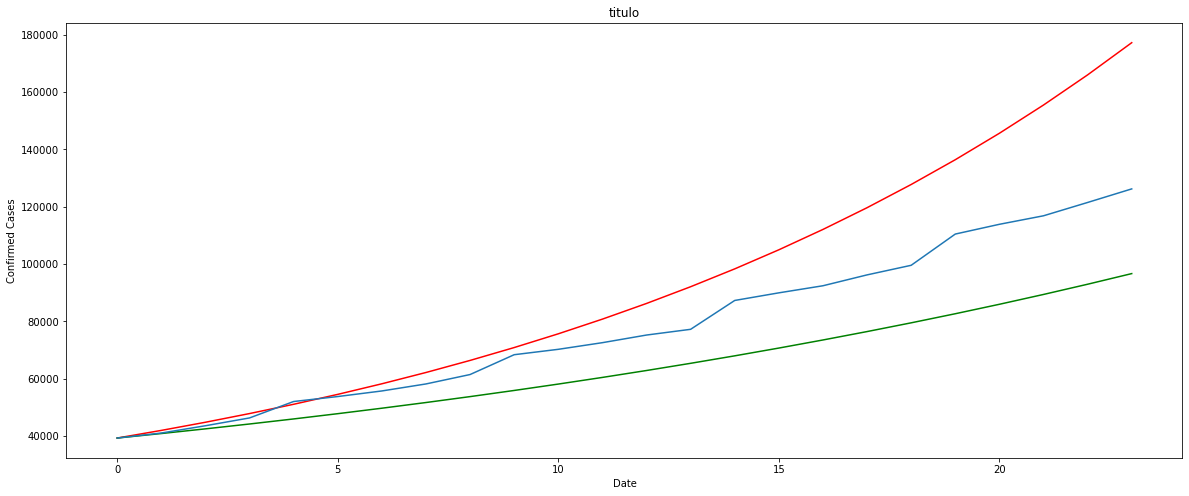

In [236]:
fig, ax = plt.subplots(figsize=(20, 8))
#ax.plot(t, np.exp(post_Pred['log_I_obs'][100].T), color="r", alpha=1)
ax.plot(t,I_sup,color='r')
ax.plot(t,I_inf,color='g')
ax.plot(t,infected)
#ax.set_yscale("log")
ax.set(xlabel="Date", ylabel="Confirmed Cases", title='titulo')
plt.show()